Plan
* Download the data and visualise it
* Transform the data
* Split into Train/Validation/Test sets

In [3]:
# import libs
import yfinance as yf
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta

In [ ]:
# Download the data

def download_stock_data(ticker_symbol):
    """
    Download stock data with error handling and validation
    """
    try:
        # Create ticker object and get history
        yticker = yf.Ticker(ticker_symbol)
        df = yticker.history(period='max')
        
        if df.empty:
            raise ValueError(f"No data downloaded for {ticker_symbol}")
            
        print(f"Downloaded {len(df)} days of {ticker_symbol} data")
        
        # Basic validation
        required_columns = ['Open', 'Close', 'Volume']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
            
        return df
    
    except Exception as e:
        print(f"Error downloading {ticker_symbol}: {str(e)}")
        return None

# Download QQQ data
ticker = "QQQ"
df = download_stock_data(ticker)

df.tail()

Downloaded 6522 days of QQQ data


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-02-04 00:00:00-05:00,518.630005,525.109985,518.229980,524.469971,26046800,0.0,0.0,0.0
2025-02-05 00:00:00-05:00,521.820007,527.010010,520.619995,526.849976,21134100,0.0,0.0,0.0
2025-02-06 00:00:00-05:00,527.359985,529.809998,525.739990,529.599976,19434500,0.0,0.0,0.0
2025-02-07 00:00:00-05:00,530.140015,532.099976,522.190002,522.919983,29605500,0.0,0.0,0.0
2025-02-10 00:00:00-05:00,527.219971,530.359985,526.750000,529.250000,20757800,0.0,0.0,0.0


In [ ]:
# Transform the data

if df is not None:
    # Add Date and Ticker columns
    df['Date'] = df.index
    df['Ticker'] = ticker
    
    # Generate features for historical prices
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Weekday'] = df.index.weekday
    
    # Calculate historical returns for different periods : 252 == 1 year ago
    for i in [1, 3, 5, 30, 90, 252]:
        df[f'growth_{i}d'] = df['Close'] / df['Close'].shift(i)
    
    # Calculate future growth (1-5 days ahead)
    for i in [1,2,3,4,5]:
        df[f'future_growth_{i}d'] = df['Close'].shift(-i) / df['Close']
    
    # Calculate 30-day rolling volatility (annualized)
    df['volatility'] = df['Close'].rolling(30).std() * np.sqrt(252)
    
    # Calculate moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # Calculate YoY growth
    df['YoY_growth'] = (df['Close'] / df['Close'].shift(252)) - 1
    
    # Split data into train/validation/test sets (60/20/20)
    total_days = len(df)
    train_end = int(total_days * 0.7)
    val_end = int(total_days * 0.9)
    
    df['split'] = 'train'
    df.iloc[train_end:val_end, df.columns.get_loc('split')] = 'validation'
    df.iloc[val_end:, df.columns.get_loc('split')] = 'test'
    
    print(f"\nData split sizes:")
    print(df['split'].value_counts())

    # # Save data to file
    # os.makedirs('data', exist_ok=True)
    # df.to_csv(f'data/{ticker}_data.csv')
    # print(f"Data saved to data/{ticker}_data.csv")


Data split sizes:
split
train         4565
validation    1304
test           653
Name: count, dtype: int64


In [28]:
df.tail(7)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Date,Ticker,...,future_growth_1d,future_growth_2d,future_growth_3d,future_growth_4d,future_growth_5d,volatility,MA20,MA50,YoY_growth,split
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-31 00:00:00-05:00,526.919983,531.520020,521.190002,522.289978,38845500,0.0,0.0,0.0,2025-01-31 00:00:00-05:00,QQQ,...,0.991997,1.004174,1.008731,1.013996,1.001206,127.443318,518.696002,517.820966,0.235349,test
2025-02-03 00:00:00-05:00,513.469971,520.849976,511.049988,518.109985,40580800,0.0,0.0,0.0,2025-02-03 00:00:00-05:00,QQQ,...,1.012275,1.016869,1.022177,1.009284,1.021501,118.869754,519.090001,518.198866,0.249943,test
2025-02-04 00:00:00-05:00,518.630005,525.109985,518.229980,524.469971,26046800,0.0,0.0,0.0,2025-02-04 00:00:00-05:00,QQQ,...,1.004538,1.009781,0.997045,1.009114,NaN,119.439648,519.384499,518.635276,0.250561,test
2025-02-05 00:00:00-05:00,521.820007,527.010010,520.619995,526.849976,21134100,0.0,0.0,0.0,2025-02-05 00:00:00-05:00,QQQ,...,1.005220,0.992541,1.004555,NaN,NaN,119.983239,519.499998,519.125076,0.235358,test
2025-02-06 00:00:00-05:00,527.359985,529.809998,525.739990,529.599976,19434500,0.0,0.0,0.0,2025-02-06 00:00:00-05:00,QQQ,...,0.987387,0.999339,NaN,NaN,NaN,123.139181,520.220998,519.633735,0.243429,test
2025-02-07 00:00:00-05:00,530.140015,532.099976,522.190002,522.919983,29605500,0.0,0.0,0.0,2025-02-07 00:00:00-05:00,QQQ,...,1.012105,NaN,NaN,NaN,NaN,123.148828,520.603496,519.992620,0.230215,test
2025-02-10 00:00:00-05:00,527.219971,530.359985,526.750000,529.250000,20757800,0.0,0.0,0.0,2025-02-10 00:00:00-05:00,QQQ,...,NaN,NaN,NaN,NaN,NaN,122.674169,521.706496,520.462132,0.232425,test


In [18]:
# Create price chart with moving averages and train/test/validation segments
fig = go.Figure()

# Add traces for each split
for split in ['train', 'validation', 'test']:
    mask = df['split'] == split
    fig.add_trace(go.Scatter(
        x=df[mask].index, 
        y=df[mask]['Close'],
        name=f'Close ({split})',
        line=dict(color='blue', width=3),
        opacity=0.7 if split == 'train' else (0.5 if split == 'validation' else 0.3)
    ))

# # Add moving averages
# fig.add_trace(go.Scatter(x=df.index, y=df['MA20'], name='MA20', line=dict(color='orange')))
# fig.add_trace(go.Scatter(x=df.index, y=df['MA50'], name='MA50', line=dict(color='red')))

fig.update_layout(
    title=f'{ticker} Price with Moving Averages and Data Splits',
    yaxis_title='Price',
    template='presentation'
)
fig.show()

# Create volume chart with splits
fig_volume = go.Figure()

for split in ['train', 'validation', 'test']:
    mask = df['split'] == split
    fig_volume.add_trace(go.Bar(
        x=df[mask].index,
        y=df[mask]['Volume'],
        name=f'Volume ({split})',
        opacity=0.7 if split == 'train' else (0.5 if split == 'validation' else 0.3)
    ))

fig_volume.update_layout(
    title=f'{ticker} Trading Volume by Split',
    yaxis_title='Volume',
    template='presentation'
)
fig_volume.show()

# Create YoY growth chart with splits
fig_yoy = go.Figure()

for split in ['train', 'validation', 'test']:
    mask = df['split'] == split
    fig_yoy.add_trace(go.Bar(
        x=df[mask].index,
        y=df[mask]['YoY_growth'],
        name=f'YoY Growth ({split})',
        opacity=0.7 if split == 'train' else (0.5 if split == 'validation' else 0.3)
    ))

fig_yoy.update_layout(
    title=f'{ticker} Year-over-Year Growth by Split',
    yaxis_title='YoY Growth %',
    template='presentation'
)
fig_yoy.show()

In [29]:
# Adding some additional calculations - Moving Average (20 and 50 days)
# with template=presentations for larger fonts 

# Create price chart with moving averages
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA20'], name='MA20', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index, y=df['MA50'], name='MA50', line=dict(color='red')))
fig.update_layout(
        title=f'{ticker} Price with Moving Averages',
        yaxis_title='Price',
        template='presentation'
    )
fig.show()

<Axes: >

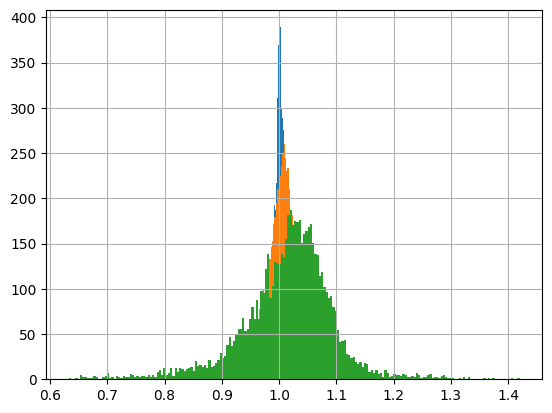

In [20]:
# Easy way of drawing histograms
df.growth_1d.hist(bins=200)
df.growth_5d.hist(bins=200)
df.growth_30d.hist(bins=200)

In [21]:
# Histograms with Plotly Express
# Reshaping Data for Plotly
df_melted = df[['growth_1d', 'growth_5d', 'growth_30d']].melt(var_name="Period", value_name="Growth")

# Create Histogram with Percent Formatting
fig = px.histogram(
    df_melted, 
    x="Growth", 
    color="Period", 
    barmode="overlay", 
    nbins=200, 
    histnorm="percent"  # Normalize to percentage
)

# Format Axes
fig.update_layout(
    xaxis=dict(tickformat=".0%"),  # Format x-axis as percentage
    yaxis=dict(title="Percentage of Total", tickformat=".1f%")  # Format y-axis as percentage
)

# Show figure
fig.update_layout(template='presentation')
fig.show()

In [22]:
# Check the distribution shape
df[['growth_1d', 'growth_5d', 'growth_30d']].describe().T

,count,mean,std,min,25%,50%,75%,max
growth_1d,6521.0,1.000530,0.017097,0.880212,0.993361,1.001144,1.008265,1.168422
growth_5d,6517.0,1.002533,0.034975,0.753810,0.985573,1.004958,1.020885,1.207195
growth_30d,6492.0,1.014892,0.081979,0.632387,0.976262,1.023027,1.060981,1.420028


# Volatility and confidence intervals (Bollinger Bands)

In [25]:
import pandas as pd
import warnings

# Calculate confidence intervals and Bollinger Bands
with warnings.catch_warnings():
    warnings.simplefilter("ignore", pd.errors.SettingWithCopyWarning)
    
    # Create a copy of 2024 data
    df_2024 = df[df.index >= '2024-01-01'].copy()
    
    # Calculate confidence intervals
    returns_std = df_2024['growth_1d'].apply(lambda x: x - 1).std()
    df_2024.loc[:,'ci_upper'] = df_2024['Close'] * (1 + 2 * returns_std)  # 95% CI
    df_2024.loc[:,'ci_lower'] = df_2024['Close'] * (1 - 2 * returns_std)  # 95% CI
    
    # Calculate Bollinger Bands
    df_2024.loc[:,'BB_middle'] = df_2024['Close'].rolling(window=20).mean()
    rolling_std = df_2024['Close'].rolling(window=20).std()
    df_2024.loc[:,'BB_upper'] = df_2024['BB_middle'] + (rolling_std * 2)
    df_2024.loc[:,'BB_lower'] = df_2024['BB_middle'] - (rolling_std * 2)

# Plot confidence intervals
fig_price = go.Figure()
fig_price.add_trace(go.Scatter(x=df_2024.index, y=df_2024['Close'], name='Close', line=dict(color='blue')))
fig_price.add_trace(go.Scatter(x=df_2024.index, y=df_2024['ci_upper'], name='Upper CI (95%)', line=dict(color='lightgray', dash='dash')))
fig_price.add_trace(go.Scatter(x=df_2024.index, y=df_2024['ci_lower'], name='Lower CI (95%)', line=dict(color='lightgray', dash='dash')))
fig_price.update_layout(
    title=f'{ticker} Price with 95% Confidence Intervals (2024)',
    yaxis_title='Price',
    template='presentation'
)
fig_price.show()

In [30]:
# Calculate rolling standard deviation
rolling_std = df['Close'].rolling(window=20).std()

# Create line plot using plotly express
fig = px.line(
    x=df.index,
    y=rolling_std,
    title='20-Day Rolling Standard Deviation',
    labels={'x': 'Date', 'y': 'Standard Deviation'},
    template='presentation'
)

# Optional: Enhance the visualization
fig.update_traces(line_color='blue', line_width=2)
fig.update_layout(
    showlegend=True,
    yaxis_title='Standard Deviation',
    hovermode='x unified'
)
fig.show()

# If you want to show splits like before:
fig = px.line(
    df,
    x=df.index,
    y=df['Close'].rolling(window=20).std(),
    color='split',  # This will color by train/validation/test
    title='20-Day Rolling Standard Deviation by Split',
    labels={'x': 'Date', 'y': 'Standard Deviation'},
    template='presentation',
    color_discrete_map={
        'train': 'rgb(31, 119, 180)',      # Blue
        'validation': 'rgb(44, 160, 44)',   # Green
        'test': 'rgb(214, 39, 40)'         # Red
    }
)
fig.update_layout(
    yaxis_title='Standard Deviation',
    hovermode='x unified'
)
fig.show()